In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, interpolate, signal, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
sigalpha = 0.05

#### Functions

In [6]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

#### Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [8]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}
c_vermillion = (213/255, 94/255, 0/255)
c_bgreen = (0/255, 158/255, 115/255)
c_skyblue = (86/255, 180/255, 233/255)

#### Set save directory

In [9]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

### Load subject

In [10]:
recfolder = r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1'
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


Set file names

In [11]:
evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
event_running_file = os.path.join(evoked_folder, 'event_running_speed.npy')
event_running_ts_file = os.path.join(evoked_folder, 'event_running_times.npy')
event_EEGtraces_file = os.path.join(evoked_folder, 'event_EEGtraces.npy')
event_EEGtraces_ts_file = os.path.join(evoked_folder, 'event_EEGtraces_times.npy')

### Load data

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})

In [13]:
event_speed = np.load(event_running_file)
event_speed_ts = np.load(event_running_ts_file)

In [14]:
event_eeg = np.load(event_EEGtraces_file)
event_eeg_ts = np.load(event_EEGtraces_ts_file)

In [15]:
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)

[2, 3, 4, 5, 8, 13]


### Find events and running speed

In [16]:
evinds = get_stim_event_inds(stim_log, 'biphasic', '40', 1, trials='all')
print(len(evinds))

118


In [17]:
ev_mBLspeed = np.mean(event_speed[event_speed_ts < 0,:][:, evinds], axis=0)
# print(ev_mBLspeed)

In [18]:
rest_events = evinds[ev_mBLspeed == 0.0]
run_events = evinds[ev_mBLspeed > 0.0]
print(len(rest_events), len(run_events))

94 24


### Spectra for each set of events

In [19]:
baseline_eeg = event_eeg[event_eeg_ts < 0, :, :]

In [20]:
chi = 22

frex, restPxx = signal.welch(
    baseline_eeg[:, chi, rest_events],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg = 2 * exp.ephys_params['EEG']['sample_rate'],
    axis = 0
)

frex, runPxx = signal.welch(
    baseline_eeg[:, chi, run_events],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg = 2 * exp.ephys_params['EEG']['sample_rate'],
    axis = 0
)

<IPython.core.display.Javascript object>


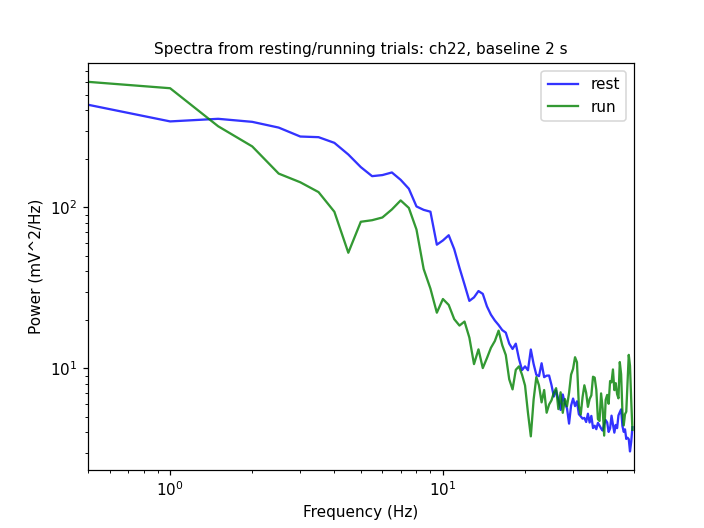

In [22]:
frinds = frex < 50

fig, ax = plt.subplots()

ax.loglog(frex[frinds], np.mean(restPxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.8, label='rest')
ax.loglog(frex[frinds], np.mean(runPxx, axis=1)[frinds], color='g', linewidth=1.5, alpha=0.8, label='run')
ax.set_xlim([0.5, 50])
ax.legend()

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra from resting/running trials: ch{:d}, baseline 2 s'.format(chi))

## Save as .png ##
figname = 'EEGspectralcomp_rest_v_run.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

<IPython.core.display.Javascript object>


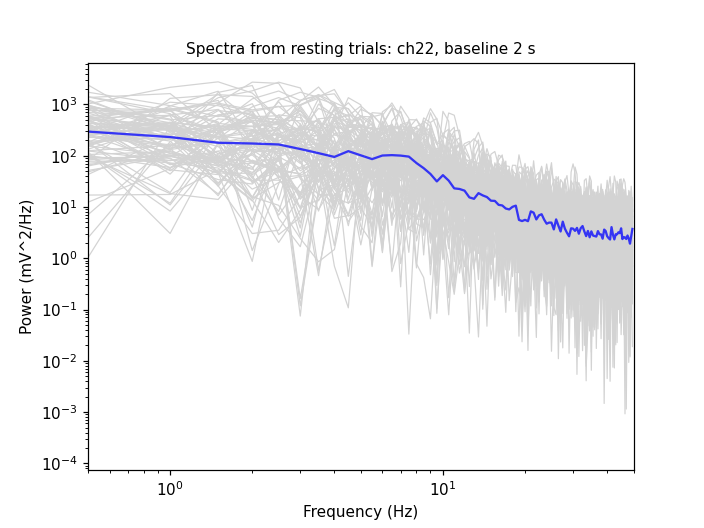

Text(0.5, 1.0, 'Spectra from resting trials: ch22, baseline 2 s')

In [34]:
frinds = frex < 50

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], restPxx[frinds,:], color='lightgray', linewidth=0.8)
ax.loglog(frex[frinds], np.median(restPxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([0.5, 50])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra from resting trials: ch{:d}, baseline 2 s'.format(chi))

<IPython.core.display.Javascript object>


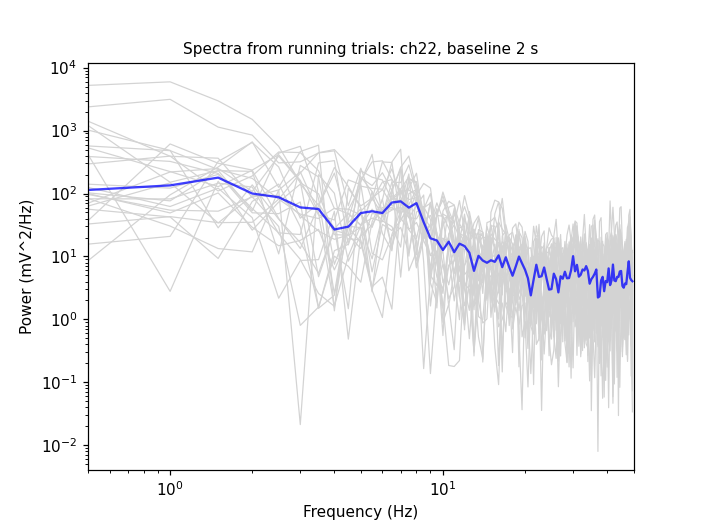

Text(0.5, 1.0, 'Spectra from running trials: ch22, baseline 2 s')

In [35]:
frinds = frex < 50

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], runPxx[frinds,:], color='lightgray', linewidth=0.8)
ax.loglog(frex[frinds], np.median(runPxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([0.5, 50])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra from running trials: ch{:d}, baseline 2 s'.format(chi))

### Plot a simple spectrum

In [19]:
print(event_eeg.shape)
print(len(stim_log))

(10000, 30, 1440)
1440


In [23]:
chi = 22
triali = 362

frex, Pxx = signal.welch(
    event_eeg[:5000, chi, triali],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg = 2 * exp.ephys_params['EEG']['sample_rate'],
    axis = 0
)

<IPython.core.display.Javascript object>


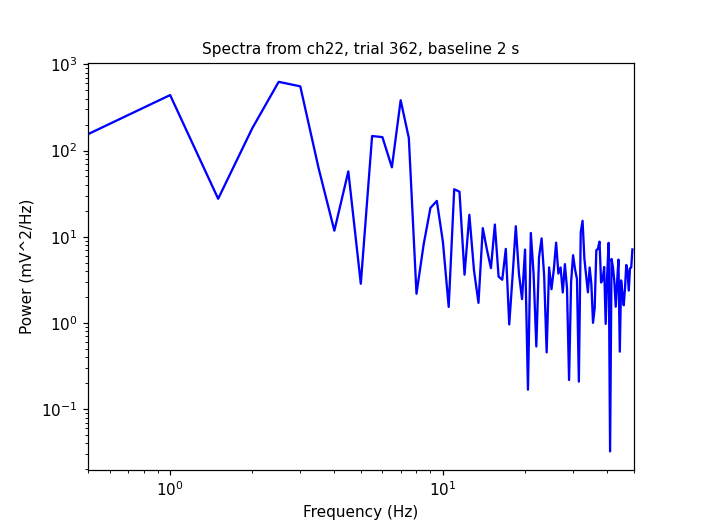

Text(0.5, 1.0, 'Spectra from ch22, trial 362, baseline 2 s')

In [25]:
frinds = frex < 50

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds], color='b', linewidth=1.5)
ax.set_xlim([0.5, 50])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra from ch{:d}, trial {:d}, baseline 2 s'.format(chi, triali))

In [10]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [11]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
        print('')

MOs_superficial

 521885
Experiment type: electrical stimulation

 521886
Experiment type: electrical stimulation

 521887
Experiment type: electrical stimulation

 543393
Experiment type: electrical stimulation

 543394
Experiment type: electrical stimulation

 575102
Experiment type: electrical and sensory stimulation

 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation

 551399
Experiment type: electrical stimulation

 551397
Experiment type: electrical and sensory stimulation

 569062
Experiment type: electrical and sensory stimulation

 569068
Experiment type: electrical and sensory stimulation

 569069
Experiment type: electrical and sensory stimulation

 569064
Experiment type: electrical and sensory stimulation

 569073
Experiment type: electrical and sensory stimulation

 571619
Experiment type: electrical stimulation

 569070
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: el

In [12]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\AI_pdfs'

### Load eeg data and gather stim-evoked traces

In [13]:
## parameters ##
chtrials = 'all' # choose: 'resting', 'running', or 'all'
apply_car = True
test_states = ['awake', 'anesthetized']

In [14]:
start = time.time()
num_good_chs = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')
        
        ## Load stim log and running signal ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
    
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(mdata['exp'].data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        
        ## Get evoked traces ##
        EEG_traces = {}
        for statei in test_states:
            sweeps = mdata['states'][statei]
            if sweeps:
                state_event_inds = []
                for sweepi in sweeps:
                    eventinds = get_stim_event_inds(stim_log, 'biphasic', str(PCI_stim_amp), sweepi, trials=chtrials)
                    if len(eventinds) == 0:
                        continue
                    state_event_inds.append(eventinds)
                if len(state_event_inds) == 0:
                    continue
                state_event_inds = np.concatenate(state_event_inds)
                
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, state_event_inds]
                
                ## Apply common avg ##
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                
                EEG_traces[statei] = [EEG_event_timestamps, event_traces]
            
        mdata['EEG_traces'] = EEG_traces
        mdata['good_chs'] = GOOD_CHS
        num_good_chs.append(len(GOOD_CHS))

        del all_EEG_traces
        del EEG_event_timestamps
        del stim_log
    print('')
end = time.time()
print('Time to load all subjects: {:.2f} mins'.format((end-start)/60))
num_good_chs = np.array(num_good_chs)

MOs_superficial
 521885
 521886
 521887
 543393
 543394
 575102
 571619

MOs_deep
 546655
 551399
 551397
 569062
 569068
 569069
 569064
 569073
 571619
 569070

SSp_superficial
 571620
 586466
 590479
 590480
 599017

SSp_deep
 569073
 569072
 571620
 586466
 590479
 590480
 599017

Time to load all subjects: 5.26 mins


In [15]:
print('Mean number of good chs: {:.1f}'.format(np.mean(num_good_chs)))
print('STD: {:.1f}'.format(np.std(num_good_chs)))
print('Min number of good chs: {:d}'.format(np.min(num_good_chs)))
print('Max number of good chs: {:d}'.format(np.max(num_good_chs)))

Mean number of good chs: 23.2
STD: 4.4
Min number of good chs: 17
Max number of good chs: 30
